## Import libraries
In this section the packages are imported.

In [140]:


import pytz
import json
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import ta

import dash
from dash import dcc, html
import plotly.graph_objs as go
import datetime

## Extracting data
In this section the necessary data is extracted. 
The Fear and Greed Index (FGI) is extracted from the CNN website.
The SPY is extracted with yfinance.

In [141]:
START_DATE = '2023-01-01'

In [142]:
def fetch_fear_greed_index(): 
        # in this section the FGI is extracted from the CNN website
        # simulating to be a human
        headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                        "AppleWebKit/537.36 (KHTML, like Gecko) "
                        "Chrome/114.0.0.0 Safari/537.36"
        }

        # the website of CNN and start date of extraction
        BASE_URL = 'https://production.dataviz.cnn.io/index/fearandgreed/graphdata'

        # importing the data from the website
        r = requests.get('{}/{}'.format(BASE_URL, START_DATE),headers=headers)
        data = r.json()

        # the data is converted into a dataframe
        fg_data = data['fear_and_greed_historical']['data']
        fear_greed_values = {}

        # for all the data the date is transformed into a normal datetime
        for data in fg_data:
                dt = datetime.datetime.fromtimestamp(data['x'] / 1000, tz=pytz.utc)
                fear_greed_values[dt.date()] = int(data['y'])

        # the values are put into a dataframe
        fear_greed_values = pd.DataFrame(fear_greed_values.values(),index=fear_greed_values.keys(),columns = ['FGI'])

        return fear_greed_values

In [143]:
def fetch_data():
    # SPY data
    spy = yf.download('SPY', start=START_DATE, interval='1d')
    spy.dropna(inplace=True)

    # Technical Indicators
    spy['200DMA'] = spy['Close'].rolling(window=200).mean()

    spy['RSI'] = ta.momentum.RSIIndicator((spy['Close'].squeeze()), window=14).rsi()

    macd = ta.trend.MACD(spy['Close'].squeeze())
    spy['MACD'] = macd.macd()
    spy['MACD_signal'] = macd.macd_signal()
    spy['MACD_hist'] = macd.macd_diff()
    
    return spy

def fetch_vix():
    vix = yf.download('^VIX', start=START_DATE, interval='1d')
    return vix['Close']

fetch_data()
fetch_vix()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker,^VIX
Date,
2023-01-03,22.900000
2023-01-04,22.010000
2023-01-05,22.459999
2023-01-06,21.129999
2023-01-09,21.969999
...,...
2025-05-20,18.090000
2025-05-21,20.870001
2025-05-22,20.280001


In [159]:
def generate_signals(df, fgi, vix):
    latest = df.iloc[-1]
    vix = vix.iloc[-1]
    fgi = fgi.iloc[-1].squeeze()
    print(fgi)

    buy = (
        fgi is not None and fgi < 30 and
        latest['Close'] > latest['200DMA'] and
        latest['RSI'] < 40 and
        latest['MACD'] > latest['MACD_signal']  # Bullish MACD crossover
    )
    
    sell = (
        fgi is not None and fgi > 70 and
        latest['RSI'] > 70 and
        vix < 15 and
        (latest['MACD'] < latest['MACD_signal'] or latest['Close'] < latest['200DMA'])
    )

    return buy, sell

spy = fetch_data()
fgi = fetch_fear_greed_index()
vix = fetch_vix()
buy, sell = generate_signals(spy, fgi, vix)
print(buy, sell)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

65
False False


c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

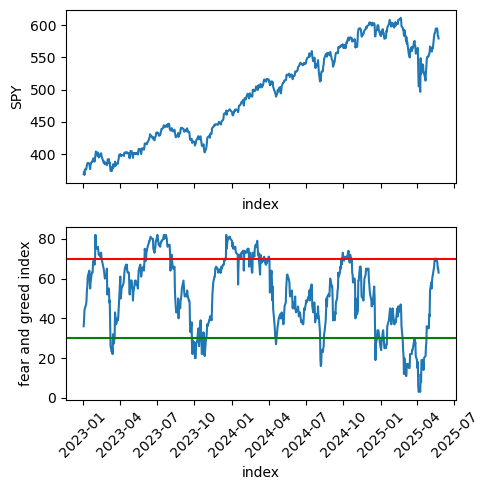

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(5,5))
sns.lineplot(data=df_comb, x = 'index',y='fear and greed index',ax=axs[1])
sns.lineplot(data=df_comb, x = 'index',y='SPY',ax=axs[0])
axs[0].set_xticklabels([])
axs[1].tick_params(axis='x', rotation=45)

axs[1].axhline(y=70,color='red')
axs[1].axhline(y=30,color='green')


plt.tight_layout()